In [1]:
!pip install ipython-autotime
!apt-get install openslide-tools
!pip install openslide-python
%load_ext autotime

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 34 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 1s (118 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 160690 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["axes.grid"] = False
import matplotlib.image as mpimg
from openslide import open_slide, __library_version__ as openslide_version
import seaborn as sns; sns.set_theme()
from sklearn.model_selection import train_test_split
import numpy as np
import pickle
import os
from PIL import Image

time: 740 ms (started: 2021-04-30 13:02:23 +00:00)


In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
tf.__version__

'2.4.1'

time: 1.53 s (started: 2021-04-30 13:02:27 +00:00)


In [4]:
# mounting the drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/
time: 16.1 s (started: 2021-04-30 13:02:31 +00:00)


In [5]:
# utlity function responsible for loading the pickle file from the file_path
def load_dataset(file_path):
    with open(file_path, 'rb') as f:
        slides, labels = pickle.load(f)
    return slides, labels

time: 1.74 ms (started: 2021-04-30 13:02:51 +00:00)


## Method 1: One Zoom Level

In [8]:
PATCH_SIZE = 32
LEVEL = 4
dataset_path = "/content/drive/MyDrive/Columbia_Assignments/ADL/Project/dataset"

train_file = os.path.join(dataset_path, 'train/camelyon_preprocessed_level' + str(LEVEL) + '.pkl')
test_file = os.path.join(dataset_path, 'test/camelyon_preprocessed_test_level' + str(LEVEL) + '.pkl')

time: 3.89 ms (started: 2021-04-30 04:01:46 +00:00)


In [9]:
# load the training dataset and labels

train_slides, train_labels = load_dataset(train_file)
train_slides = np.array(train_slides)
train_labels = np.array(train_labels)
print("Training slides length: {}".format(len(train_slides)))
print("Train labels: {}".format(train_labels))
print("Number of cancerous labels: {}".format(np.sum(train_labels)))

Training slides length: 146570
Train labels: [0 0 0 ... 0 0 0]
Number of cancerous labels: 8724
time: 8.7 s (started: 2021-04-30 04:01:49 +00:00)


In [10]:
# load the test dataset and labels

test_slides, test_labels = load_dataset(test_file)
test_slides = np.array(test_slides)
test_labels = np.array(test_labels)
print("Test slides length: {}".format(len(test_slides)))
print("Test labels: {}".format(test_labels))
print("Number of cancerous labels: {}".format(np.sum(test_labels)))

Test slides length: 63840
Test labels: [0 0 0 ... 0 0 0]
Number of cancerous labels: 5517
time: 3.78 s (started: 2021-04-30 04:02:45 +00:00)


### Splitting the training dataset into validation and training


In [11]:
train_slides, val_slides, train_labels, val_labels = train_test_split(train_slides, train_labels)
print("Validation slides length: {}".format(len(val_slides)))
print("Validation labels: {}".format(val_labels))
print("Number of cancerous labels: {}".format(np.sum(val_labels)))

Validation slides length: 36643
Validation labels: [0 0 0 ... 0 0 0]
Number of cancerous labels: 2259
time: 148 ms (started: 2021-04-30 04:02:52 +00:00)


### Custom Model: Without Data Augmentation

In [12]:
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(PATCH_SIZE, PATCH_SIZE, 3)))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation='sigmoid'))

time: 370 ms (started: 2021-04-30 04:02:59 +00:00)


In [13]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

time: 20 ms (started: 2021-04-30 04:03:03 +00:00)


In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        9280      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 6, 6, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2

### Train the model

In [15]:
epochs = 10
callbacks = [
    keras.callbacks.ModelCheckpoint(os.path.join(dataset_path, 'model/save_at_{epoch}.h5')),
]


history = model.fit(
    train_slides, train_labels,
    validation_data=(val_slides, val_labels),
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/10
3436/3436 [==============================] - 78s 23ms/step - loss: 0.3316 - accuracy: 0.9351 - val_loss: 0.1744 - val_accuracy: 0.9384
Epoch 2/10
3436/3436 [==============================] - 77s 22ms/step - loss: 0.1562 - accuracy: 0.9421 - val_loss: 0.1540 - val_accuracy: 0.9383
Epoch 3/10
3436/3436 [==============================] - 77s 22ms/step - loss: 0.1548 - accuracy: 0.9433 - val_loss: 0.1706 - val_accuracy: 0.9384
Epoch 4/10
3436/3436 [==============================] - 79s 23ms/step - loss: 0.1498 - accuracy: 0.9445 - val_loss: 0.1270 - val_accuracy: 0.9597
Epoch 5/10
3436/3436 [==============================] - 77s 22ms/step - loss: 0.1362 - accuracy: 0.9590 - val_loss: 0.1266 - val_accuracy: 0.9611
Epoch 6/10
3436/3436 [==============================] - 78s 23ms/step - loss: 0.1323 - accuracy: 0.9603 - val_loss: 0.1260 - val_accuracy: 0.9619
Epoch 7/10
3436/3436 [==============================] - 76s 22ms/step - loss: 0.1499 - accuracy: 0.9553 - val_loss: 0.1221 -

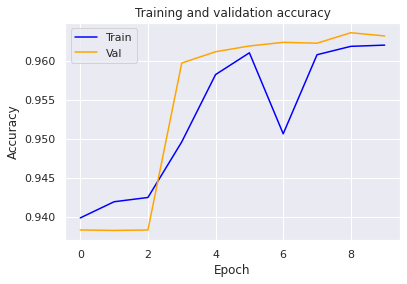

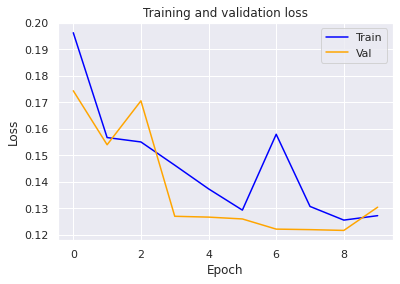

time: 745 ms (started: 2021-04-30 04:19:14 +00:00)


In [16]:
# Your code here
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get the number of epochs
epochs = range(len(acc))

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, color='blue', label='Train')
plt.plot(epochs, val_acc, color='orange', label='Val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

_ = plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, color='blue', label='Train')
plt.plot(epochs, val_loss, color='orange', label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

### Test the model on the test data

In [17]:
# load the test tumor tifs
test_tumor_path = os.path.join(dataset_path, 'test/tumor')
test_tumor_mask_path = os.path.join(dataset_path, 'test/tumor_mask')

test_tumors_tifs = []
test_tumors_mask_tifs = []

for filename in os.listdir(test_tumor_path):
    test_tumors_tifs.append(os.path.join(test_tumor_path, filename))    
for filename in os.listdir(test_tumor_mask_path):
    test_tumors_mask_tifs.append(os.path.join(test_tumor_mask_path, filename))

test_tumors_tifs.sort()
test_tumors_mask_tifs.sort()
print("Length of test tumor tiffs: {}".format(len(test_tumors_tifs)))
print("Length of test tumor mask tiffs: {}".format(len(test_tumors_mask_tifs)))

Length of test tumor tiffs: 2
Length of test tumor mask tiffs: 2
time: 28.7 ms (started: 2021-04-30 04:19:38 +00:00)


In [18]:
# create separate test_slides and test_labels for each of the two test tifs
# identify the patch index where the first tiff patches end, and the second tiff patches starts.
# this is denoted by first_index

stride_width_array = [272, 184]
stride_height_array = [140, 140]

first_index = stride_height_array[0]*stride_width_array[0]
test_slides_normal_1 = test_slides[:first_index]
test_labels_normal_1 = test_labels[:first_index]

test_slides_normal_2 = test_slides[first_index:]
test_labels_normal_2 = test_labels[first_index:]

print("first_tiff_index: ", first_index)
print("length: ", test_labels_normal_1)
print("number of cancerous cells: ", np.sum(test_labels_normal_1))

print("length: ", test_labels_normal_2)
print("number of cancerous cells: ", np.sum(test_labels_normal_2))

first_tiff_index:  38080
length:  [0 0 0 ... 0 0 0]
number of cancerous cells:  948
length:  [0 0 0 ... 0 0 0]
number of cancerous cells:  4569
time: 18.2 ms (started: 2021-04-30 04:19:47 +00:00)


### Predicting the first test tiff file

In [19]:
predictions = model.predict(test_slides_normal_1)

time: 8.44 s (started: 2021-04-30 04:19:51 +00:00)


In [20]:
print("length of predictions: {}".format(len(predictions)))
print("predictions: {}".format(predictions))

length of predictions: 38080
predictions: [[0.00180888]
 [0.00181362]
 [0.00182429]
 ...
 [0.00170836]
 [0.00163442]
 [0.00162873]]
time: 1.96 ms (started: 2021-04-30 04:20:05 +00:00)


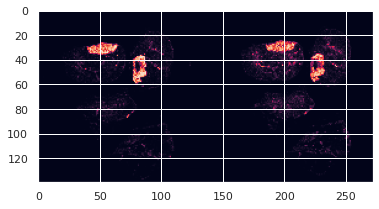

time: 500 ms (started: 2021-04-30 04:20:09 +00:00)


In [21]:
plt.imshow(np.reshape(predictions, (272, 140)).T)

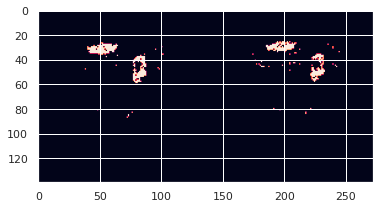

time: 320 ms (started: 2021-04-30 04:20:15 +00:00)


In [22]:
# temp = np.round(predictions)
THRESHOLD = 0.5
threshold_predictions = np.where(predictions > THRESHOLD, 1, 0)
plt.imshow(np.reshape(threshold_predictions, (272, 140)).T)

### F1-Score

In [23]:
from sklearn.metrics import classification_report

classification_metrics = classification_report(threshold_predictions, test_labels_normal_1)
print(classification_metrics)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     37481
           1       0.59      0.94      0.73       599

    accuracy                           0.99     38080
   macro avg       0.80      0.96      0.86     38080
weighted avg       0.99      0.99      0.99     38080

time: 53.5 ms (started: 2021-04-30 04:20:19 +00:00)


### IOU Measure

In [25]:
y_pred_image = np.reshape(threshold_predictions, (272, 140))
y_true_image = np.reshape(test_labels_normal_1, (272, 140))

inter = np.logical_and(y_pred_image, y_true_image)
union = np.logical_or(y_pred_image, y_true_image)

print(np.sum(inter)/float(np.sum(union)))

0.5705583756345177
time: 8.51 ms (started: 2021-04-30 04:20:31 +00:00)


### Heatmap for the test tif

In [26]:
# read slide and return an image
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

time: 7.47 ms (started: 2021-04-30 04:20:38 +00:00)


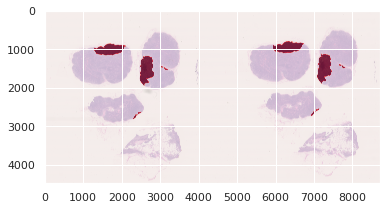

time: 8.04 s (started: 2021-04-30 04:20:43 +00:00)


In [27]:
# show a slide
tumor_image = open_slide(test_tumors_tifs[0])
mask_image = open_slide(test_tumors_mask_tifs[0])

width = tumor_image.level_dimensions[LEVEL][0]
height = tumor_image.level_dimensions[LEVEL][1]

tumor_slide = read_slide(tumor_image, 0, 0, LEVEL, width=width, height=height)
mask_slide = read_slide(mask_image, 0, 0, LEVEL, width=width, height=height)

plt.imshow(tumor_slide)
plt.imshow(mask_slide[:, :, 0], cmap='Reds', alpha=0.7)
plt.show()

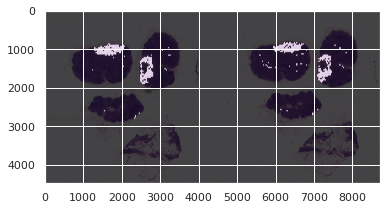

time: 22.8 s (started: 2021-04-30 04:21:27 +00:00)


In [28]:
# plot the patches to see if patch extraction is working properly
step_width = width // PATCH_SIZE
step_height = height // PATCH_SIZE

canvas_slide = Image.new('RGB', (PATCH_SIZE * step_width, PATCH_SIZE * step_height), 'white')
canvas_mask = Image.new('RGB', (PATCH_SIZE * step_width, PATCH_SIZE * step_height), 'white')

mask_blank = np.zeros((PATCH_SIZE, PATCH_SIZE))
mask_tumor = 255 * np.ones((PATCH_SIZE, PATCH_SIZE))

index = 0

for i in range(step_width):
    for j in range(step_height):
        canvas_slide.paste(Image.fromarray(test_slides_normal_1[index], 'RGB'), (i*PATCH_SIZE, j*PATCH_SIZE))
        if threshold_predictions[index] == 0:
            canvas_mask.paste(Image.fromarray(mask_blank), (i*PATCH_SIZE, j*PATCH_SIZE))
        else:
            canvas_mask.paste(Image.fromarray(mask_tumor), (i*PATCH_SIZE, j*PATCH_SIZE))
        index += 1

slide_name = 'patch_to_slide.png'
mask_name = 'patch_to_mask.png'
canvas_slide.save(slide_name)
canvas_mask.save(mask_name)
image_slide = plt.imread(slide_name)
image_mask = plt.imread(mask_name)

plt.imshow(image_slide)
plt.imshow(image_mask, cmap='jet', alpha=0.7)

### Predicting the second tiff file

In [29]:
predictions_2 = model.predict(test_slides_normal_2)

time: 5.66 s (started: 2021-04-30 04:21:57 +00:00)


In [30]:
print("length of predictions: {}".format(len(predictions_2)))
print("predictions: {}".format(predictions_2))

length of predictions: 25760
predictions: [[0.00125578]
 [0.00113297]
 [0.00137514]
 ...
 [0.00104704]
 [0.00114307]
 [0.00122961]]
time: 2.18 ms (started: 2021-04-30 04:22:08 +00:00)


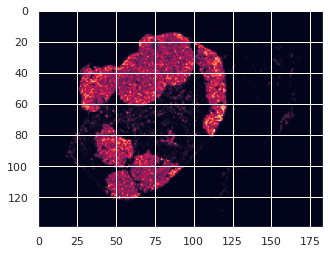

time: 341 ms (started: 2021-04-30 04:22:11 +00:00)


In [31]:
plt.imshow(np.reshape(predictions_2, (184, 140)).T)

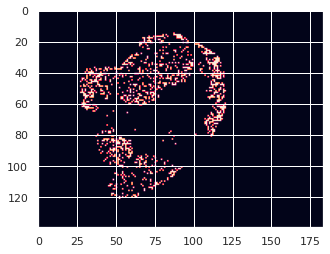

time: 324 ms (started: 2021-04-30 04:22:15 +00:00)


In [32]:
# temp = np.round(predictions)
THRESHOLD = 0.5
threshold_predictions = np.where(predictions_2 > THRESHOLD, 1, 0)
plt.imshow(np.reshape(threshold_predictions, (184, 140)).T)

In [33]:
from sklearn.metrics import classification_report

classification_metrics = classification_report(threshold_predictions, test_labels_normal_2)
print(classification_metrics)

              precision    recall  f1-score   support

           0       1.00      0.86      0.92     24649
           1       0.24      0.99      0.39      1111

    accuracy                           0.86     25760
   macro avg       0.62      0.92      0.66     25760
weighted avg       0.97      0.86      0.90     25760

time: 35.5 ms (started: 2021-04-30 04:22:20 +00:00)


### Heatmap for the test file

In [34]:
# read slide and return an image
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

time: 7.8 ms (started: 2021-04-30 04:22:23 +00:00)


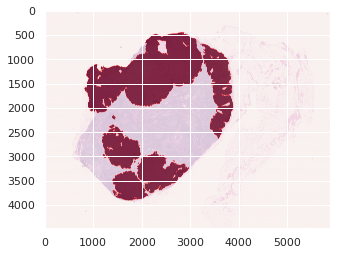

time: 6.1 s (started: 2021-04-30 04:22:25 +00:00)


In [35]:
# show a slide
tumor_image = open_slide(test_tumors_tifs[1])
mask_image = open_slide(test_tumors_mask_tifs[1])

width = tumor_image.level_dimensions[LEVEL][0]
height = tumor_image.level_dimensions[LEVEL][1]

tumor_slide = read_slide(tumor_image, 0, 0, LEVEL, width=width, height=height)
mask_slide = read_slide(mask_image, 0, 0, LEVEL, width=width, height=height)

plt.imshow(tumor_slide)
plt.imshow(mask_slide[:, :, 0], cmap='Reds', alpha=0.7)
plt.show()

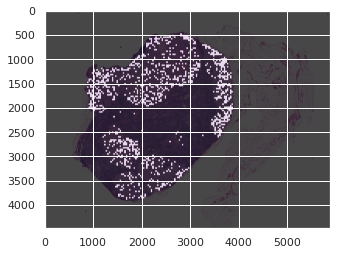

time: 16.1 s (started: 2021-04-30 04:23:40 +00:00)


In [36]:
# plot the patches to see if patch extraction is working properly
step_width = width // PATCH_SIZE
step_height = height // PATCH_SIZE
canvas_slide = Image.new('RGB', (PATCH_SIZE * step_width, PATCH_SIZE * step_height), 'white')
canvas_mask = Image.new('RGB', (PATCH_SIZE * step_width, PATCH_SIZE * step_height), 'white')
mask_blank = np.zeros((PATCH_SIZE, PATCH_SIZE))
mask_tumor = 255 * np.ones((PATCH_SIZE, PATCH_SIZE))
index = 0

for i in range(step_width):
    for j in range(step_height):
        canvas_slide.paste(Image.fromarray(test_slides_normal_2[index], 'RGB'), (i*PATCH_SIZE, j*PATCH_SIZE))
        if threshold_predictions[index] == 0:
            canvas_mask.paste(Image.fromarray(mask_blank), (i*PATCH_SIZE, j*PATCH_SIZE))
        else:
            canvas_mask.paste(Image.fromarray(mask_tumor), (i*PATCH_SIZE, j*PATCH_SIZE))
        index += 1

slide_name = 'patch_to_slide.png'
mask_name = 'patch_to_mask.png'
canvas_slide.save(slide_name)
canvas_mask.save(mask_name)
image_slide = plt.imread(slide_name)
image_mask = plt.imread(mask_name)

plt.imshow(image_slide)
plt.imshow(image_mask, cmap='Reds', alpha=0.7)